![Group Logo](./MSU_Hollow_Earth_Society_Logo_v3.jpg)

# AST 304 Project 3 Writeup

Elias Taira, Michael Bellaver, Joe Epley , Erin Syerson

In [5]:
import numpy as np
from structure import central_thermal, integrate
from eos import mean_molecular_weight
from zams import Teff, surface_luminosity
from scipy.optimize import brentq
import matplotlib.pyplot as plt
%matplotlib inline

### 1) Verifying $P_c$ and $\rho_c$ Scalings

In verifying the scalings of $P_c$ and $\rho_c$ that we found from project 2 (which are 0.77 ($\alpha$) and 5.99 ($\beta$) respectively), we adjust the polytropic constant by factors of 0.5 and 2 to see if the scalings change.

To do so, we must first utilize project 2 code (which unfortunately make this repo way bigger than it was), then run the 'testing_central_consts.py' file we created, to ensure that $\alpha$ and $\beta$ remain constant.

In [6]:
! python ./testing_central_consts.py

0.5 * K:
\alpha = 0.7695941638047205 \beta = 5.987670533574357
1.25 * K:
\alpha = 0.7695941638047196 \beta = 5.98767053357435
2.0 * K:
\alpha = 0.7695941638047192 \beta = 5.9876705335743505


As we can see from the above code, the $\alpha$ and $\beta$ values remain constant for a ange of values about K

### Defining Physical Constants

For our code, we define all of our physical and astronomical constants in the astro_const.py file. However, since we do not need to use all of the constants contained within the file for this writup, we will only be importing the values that we need.

In [7]:
from astro_const import Rsun, Msun, Lsun

### Testing Modules

In the following cell, we prove the functionality of the newly introduced functions via the *testing.py* script we were provided

In [8]:
! python ./testing.py

cosntants passed testing
chemistry passed testing
adiabatic EOS passed testing
reactions passed testing
central temperature passed testing
effective temperature passed testing
surface luminosity passed testing


### Convergence Testing

When adjusting $\delta_m$ we lowered it until we got converged values and then put it to the first value, $M_\odot \times 10^{-18}$, that gave us those converged values.

For our choice of $\eta$ we went with a value that would ensure that our integration stopped once we reached the edge of the star (i.e., the pressure is 0).Thus, we would need a value that was sufficiently small, but if the value was too small, the code would iterate past the edge of the star and result in negative pressures (which of course would cause our code to immediately explode). After some experimentation, we found that a $\eta$ of around $1 \times 10^{20}$ would meet both of these criertia very nicely

For $\xi$, once the value is above 1.75, it starts to iterate over empty space, which begins to return negative pressures, and if $\xi$ is lower than approximately 0.003 it begins to take too many iterations.

### Results

In [9]:
# using the constants from the last project
delta_m = Msun*1e-18
eta = 1e-20
xi = 5e-2

pp_rate = 1

# mass ratio of hydrogen
XH = 0.706

# z, x, and a arrays for the makeup of the star
Z = np.array([1,2,7])
A = np.array([1,4, 14])
X = np.array([XH, 0.275, 0.019])

mu = mean_molecular_weight(Z,A,X)

# defining the minimizing function
def min_this(R_guess, S_mass, delta_m, eta, xi, mu, pp):
    
    '''
    minimizes the difference between the surface luminosity
        and the luminosity from the nuclear reactions 
        at the center of the star
        
    arguments:
        R_guess (scalar)
            guess for the final radius
        S_mass (scalar)
            mass of the given star
        delta_m (scalar)
            steps for integrating through mass
        eta (scalar)
            determines the stopping point of the iterations
        xi (scalar)
            helps determine step size
        mu (scalar)
            mean molecular weight
            
    returns:
        L_want - l[-1]
            difference in luminosities mentioned above
    '''

    Pc, rhoc, Tc = central_thermal(S_mass, R_guess, mu)

    m, r, p, l = integrate(Pc,rhoc,Tc,delta_m,eta,xi,mu,pp_factor = pp)

    # calculating desired radius
    L_want = surface_luminosity(Teff(S_mass*Msun),r[-1])

    return L_want - l[-1]

# list of masses we are using
mass_list = np.array([0.1, 0.15, 0.2, 0.3])

# initializing a ton of stuff
L_list = np.zeros(len(mass_list))
Teff_list = np.zeros(len(mass_list))
rhoc_list = np.zeros(len(mass_list))
Tc_list = np.zeros(len(mass_list))
R_list = np.zeros(len(mass_list))

# iterates through all of masses and finds the wanted luminosities
for i,S_mass in enumerate(mass_list):
    
    R_final = brentq(min_this,a = 0.0001, b = 1, args = (S_mass, delta_m, eta, xi, mu, pp_rate))

    T_surf = Teff(S_mass)

    Teff_list[i] = T_surf

    L_list[i] = surface_luminosity(T_surf,R_final*Rsun)/Lsun

    Pc, rhoc, Tc = central_thermal(S_mass, R_final, mu)

    rhoc_list[i] = 1000*rhoc/(100**3)

    Tc_list[i] = Tc

    R_list[i] = R_final

print(R_final)
print(L_list[-1])

c:\Users\elias\Desktop\AST 304\AST_304_Projects\project3\structure.py:141: RuntimeWarning: overflow encountered in true_divide
  H_z = z/np.abs(dzdm)
c:\Users\elias\Desktop\AST 304\AST_304_Projects\project3\structure.py:141: RuntimeWarning: divide by zero encountered in true_divide
  H_z = z/np.abs(dzdm)


0.3113666213832169
0.011671449011444983


Stellar masses from left to right are: 0.3, 0.2, 0.15, 0.1, all in solar masses


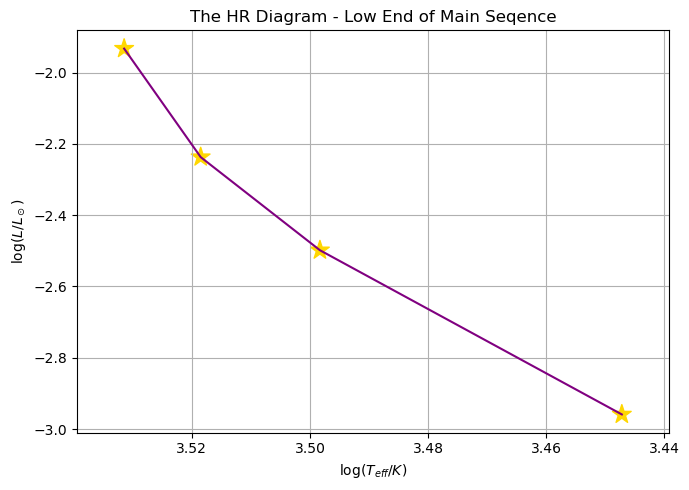

In [21]:
# plotting the HR Diagram
import matplotlib.pyplot as plt

plt.figure(figsize = (7,5))
plt.plot(np.log10(Teff_list), np.log10(L_list), color = 'purple')
plt.scatter(np.log10(Teff_list), np.log10(L_list), color = 'gold',  marker = '*', s = [200,200,200,200])
plt.title("The HR Diagram - Low End of Main Seqence")
plt.xlabel(r"log($T_{eff}/K$)")
plt.ylabel(r"log($L/L_\odot$)")
plt.xlim(max(np.log10(Teff_list))+.008, min(np.log10(Teff_list))-.008)
plt.grid()
plt.tight_layout()
print('Stellar masses from left to right are: 0.3, 0.2, 0.15, 0.1, all in solar masses')

<img src="./fig15.jpg" width="500" height="500">

In comparing the two plots together, the specified stellar mass range appears to be very similar to the data shown by Paxton et al.

Stellar masses from left to right are: 0.3, 0.2, 0.15, 0.1, all in solar masses


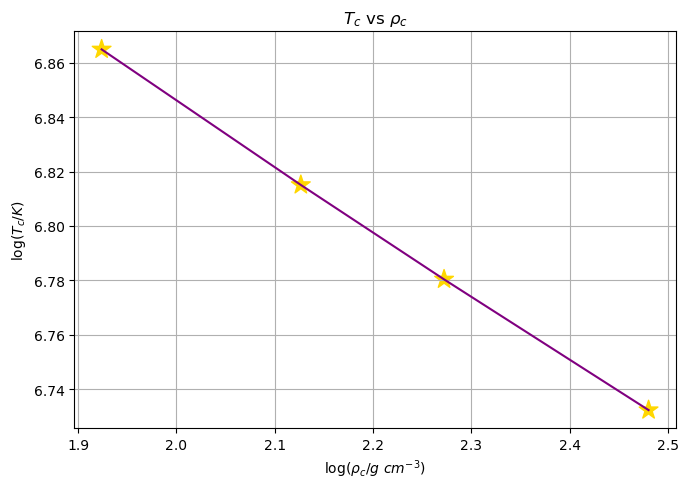

In [22]:
# plotting central temp and pressure for a 0.3 mass star
plt.figure(figsize = (7,5))
plt.plot(np.log10(rhoc_list), np.log10(Tc_list), color = 'purple')
plt.scatter(np.log10(rhoc_list), np.log10(Tc_list), color = 'gold',  marker = '*', s = [200,200,200,200])
plt.title(r"$T_c$ vs $\rho_c$")
plt.xlabel(r"log($\rho_c /g$ $cm^{-3}$)")
plt.ylabel(r"log($T_c/K$)")
plt.tight_layout()
plt.grid()
print('Stellar masses from left to right are: 0.3, 0.2, 0.15, 0.1, all in solar masses')

<img src="./fig16.jpg" width="500" height="500">

In comparing the two plots together, the Central Temperature vs Central Denstiy we generated appears to be very similar to the data shown by Paxton et al.

#### 0.3 $M_{\odot}$ Star Analysis

In [13]:
R_final = brentq(min_this,a = 0.01, b = 1, xtol = 1e-10,args = (.3, delta_m, eta, xi, mu, pp_rate))
Pc, rhoc, Tc = central_thermal(.3, R_final, mu)
m, r, p, l = integrate(Pc,rhoc,Tc,delta_m,eta,xi,mu,pp_factor = pp_rate)

c:\Users\elias\Desktop\AST 304\AST_304_Projects\project3\structure.py:141: RuntimeWarning: overflow encountered in true_divide
  H_z = z/np.abs(dzdm)
c:\Users\elias\Desktop\AST 304\AST_304_Projects\project3\structure.py:141: RuntimeWarning: divide by zero encountered in true_divide
  H_z = z/np.abs(dzdm)


Below, we show a plot of the mass vs luminosity of the 0.3 $M_{\odot}$ Star. Unlike in the previous plots, we do not work in a log scale

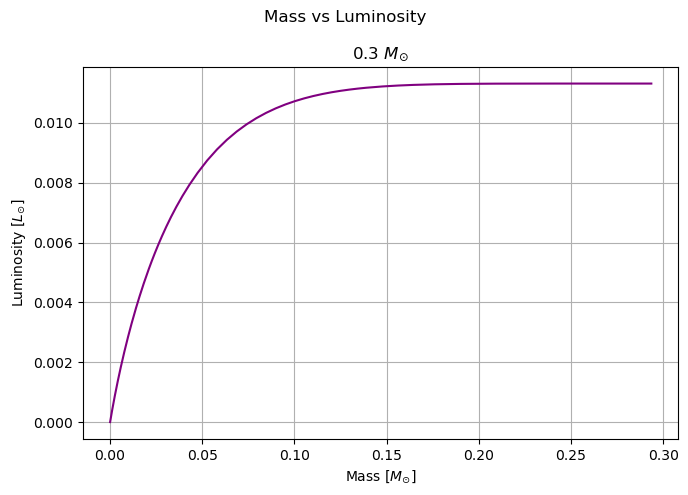

In [19]:
# plotting mass and luminosity for a 0.3 mass star
plt.figure(figsize = (7,5))
plt.plot(m/Msun,l/Lsun, color = 'purple')
plt.title('0.3 $M_{\odot}$')
plt.suptitle('Mass vs Luminosity')
plt.xlabel('Mass [$M_{\odot}$]')
plt.ylabel('Luminosity [$L_{\odot}$]')
plt.tight_layout()
plt.grid()

Now, we plot the star's luminosity as a function of its radius. Once again, in solar units.

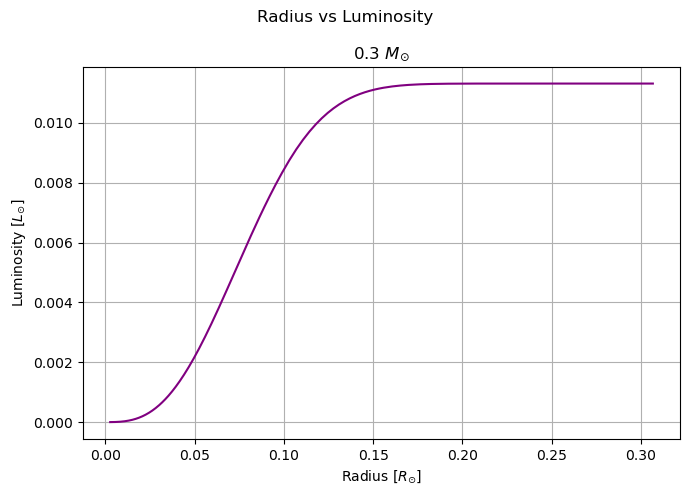

In [16]:
# plotting radius and luminosity for a 0.3 mass star
plt.figure(figsize = (7,5))
plt.plot(r/Rsun,l/Lsun, color = 'purple')
plt.suptitle('Radius vs Luminosity')
plt.title('0.3 $M_{\odot}$')
plt.xlabel('Radius [$R_{\odot}$]')
plt.ylabel('Luminosity [$L_{\odot}$]')
plt.tight_layout()
plt.grid()

We now find the radius and mass in which the star's luminosity is at 90% of its total value. 

We find that this occurs about 40% of the way through the star at about 28% of the star's mass.

In [17]:
# finding the radius when the luminosity is at 90%
ninety_rad = r[np.max(np.where(l <= np.max(l)*0.9))]

print('90% radius:', round(ninety_rad/6.957e8,5), 'solar radii')
print('90% radius:', round(ninety_rad,2), 'meters')

print('\ncheck to match instructions: ', round(ninety_rad/r[-1],4))

90% radius: 0.12124 solar radii
90% radius: 84348145.29 meters

check to match instructions:  0.3954


In [18]:
# finding the mass when the luminosity is at 90%
ninety_mass = m[np.max(np.where(l <= np.max(l)*0.9))]

print('90% mass:', round(ninety_mass/(.3*Msun),5), 'solar masses')
print('90% mass:', round(ninety_mass, -3), 'kg')

print('\ncheck to match instructions: ', round(ninety_mass/m[-1],4))

90% mass: 0.2644 solar masses
90% mass: 1.5772079912820235e+29 kg

check to match instructions:  0.2702


Below are plots very similar to the luminosity plots, but now using tempurature rather than luminosity.

In [40]:
# calculating tempurature
T = Tc*(p/Pc)**(1-1/(5/3))

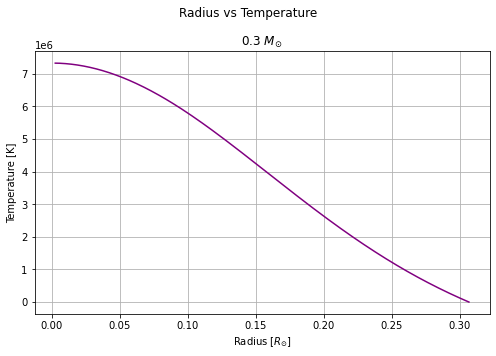

In [41]:
# plotting radius and temperature for a 0.3 mass star
plt.figure(figsize = (7,5))
plt.plot(r/6.957e8,T, color = 'purple')
plt.xlabel('Radius [$R_{\odot}$]')
plt.ylabel('Temperature [K]')
plt.suptitle('Radius vs Temperature')
plt.title('0.3 $M_{\odot}$')
plt.tight_layout()
plt.grid()

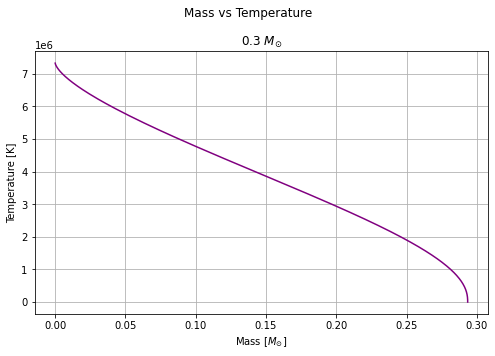

In [42]:
# plotting mass and temperature for a 0.3 mass star
plt.figure(figsize = (7,5))
plt.plot(m/1.989e30,T, color = 'purple')
plt.xlabel('Mass [$M_{\odot}$]')
plt.ylabel('Temperature [K]')
plt.suptitle('Mass vs Temperature')
plt.title('0.3 $M_{\odot}$')
plt.tight_layout()
plt.grid()

### What Would Happen?

In the following cell, we see what happens when we increase the value of the pp_rate to the stars and their porperties

In [23]:
# using the constants from the last project
delta_m = Msun*1e-18
eta = 1e-20
xi = 5e-2

# changing the pp_rate from 1 to 1e5 
pp_rate_enhanced = 1e5

# mass ratio of hydrogen
XH = 0.706

# z, x, and a arrays for the makeup of the star
Z = np.array([1,2,7])
A = np.array([1,4, 14])
X = np.array([XH, 0.275, 0.019])

mu = mean_molecular_weight(Z,A,X)

# defining the minimizing function
def min_this(R_guess, S_mass, delta_m, eta, xi, mu, pp):
    
    '''
    minimizes the difference between the surface luminosity
        and the luminosity from the nuclear reactions 
        at the center of the star
        
    arguments:
        R_guess (scalar)
            guess for the final radius
        S_mass (scalar)
            mass of the given star
        delta_m (scalar)
            steps for integrating through mass
        eta (scalar)
            determines the stopping point of the iterations
        xi (scalar)
            helps determine step size
        mu (scalar)
            mean molecular weight
            
    returns:
        L_want - l[-1]
            difference in luminosities mentioned above
    '''

    Pc, rhoc, Tc = central_thermal(S_mass, R_guess, mu)

    m, r, p, l = integrate(Pc,rhoc,Tc,delta_m,eta,xi,mu,pp_factor = pp)

    # calculating desired radius
    L_want = surface_luminosity(Teff(S_mass*Msun),r[-1])

    return L_want - l[-1]

# list of masses we are using
mass_list = np.array([0.1, 0.15, 0.2, 0.3])

# initializing a ton of stuff
L_list2 = np.zeros(len(mass_list))
Teff_list2 = np.zeros(len(mass_list))
rhoc_list2 = np.zeros(len(mass_list))
Tc_list2 = np.zeros(len(mass_list))
R_list2 = np.zeros(len(mass_list))

# iterates through all of masses and finds the wanted luminosities
for i,S_mass in enumerate(mass_list):
    
    R_final2 = brentq(min_this,a = 0.0001, b = 1, args = (S_mass, delta_m, eta, xi, mu, pp_rate_enhanced))

    T_surf = Teff(S_mass)

    Teff_list2[i] = T_surf

    L_list2[i] = surface_luminosity(T_surf,R_final2*Rsun)/Lsun

    Pc, rhoc, Tc = central_thermal(S_mass, R_final2, mu)

    rhoc_list2[i] = 1000*rhoc/(100**3)

    Tc_list2[i] = Tc

    R_list2[i] = R_final2

print(R_final2/R_final)
print(L_list2[-1]/L_list[-1])

c:\Users\elias\Desktop\AST 304\AST_304_Projects\project3\structure.py:141: RuntimeWarning: overflow encountered in true_divide
  H_z = z/np.abs(dzdm)
c:\Users\elias\Desktop\AST 304\AST_304_Projects\project3\structure.py:141: RuntimeWarning: divide by zero encountered in true_divide
  H_z = z/np.abs(dzdm)


2.753199502203825
7.580107498949242


We found that the radius has increaced by a factor of 2.75 and the luminosity has increased by a factor of 7.58. If this were to happen with our sun, it would mean that Earth is most definitely not going to be in our solar system's habitable zone, and we would not be able to survive on earth any longer. The surface temperture of the Earth would skyrocket.